# GreenValueNet

This notebook contains the code needed to execute the GreenValueNet hedonic pricing neural network. 

### Set up and data loading

In [1]:
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from data_load_funcs import get_params, load_data_catalogue
from processing_funcs import process_data, normalise_values
from model_funcs import *

cwd = Path.cwd()
params = get_params()
data_catalogue = load_data_catalogue()

c:\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


If you do not have a file called `dataset.csv` in the `data/interim_files` folder the following cell will generate this folder and generate summary statistics. The data processing happens locally and invovles large datasets with spatial components so can take quite several hours - please be pateint! If you already have the file, it will be read in and summary statistics are generated. 

In [4]:
dataset = process_data(data_catalogue, params)

# show summary stats
summary_stats = dataset.describe().transpose()[['mean', 'std', 'max', 'min']]
summary_stats.columns = ['Mean', 'Std Dev', 'Maximum', 'Minimum']
print(summary_stats)

                                  Mean    Std Dev       Maximum   Minimum
ln_price                     12.380537   0.671172     17.600118  0.133949
propertytype                  1.312324   1.083203      3.000000  0.000000
oldnew                        0.122618   0.327998      1.000000  0.000000
duration                      0.323910   0.468001      2.000000  0.000000
current_energy_efficiency    61.022291  12.291185    162.000000  0.000000
potential_energy_efficiency   0.805091   0.141672     70.000000  0.000000
total_floor_area             90.492569  80.334532  60506.700000  0.000000
extension_count               0.488239   0.733135      4.000000  0.000000
number_habitable_rooms        4.476421   1.731979    100.000000  0.000000
number_heated_rooms           4.394302   1.731866    100.000000  0.000000
construction_age_band         4.860699   3.503979     12.000000 -1.000000
coastline_dist               60.345059  37.749882    135.732016  0.004453
prim_school_dist              0.790663

Now we normalise any non-encoded variables to increase speed of learning of algorithm and convert the dataset to an array of inputs, and an associated output array.

In [5]:
norm_cols = [col for col in dataset.columns if col not in params['non_norm_cols']]
for col in norm_cols:
    dataset[col] = normalise_values(dataset[col])

# creates an arry of shape m, x, y
x, y, derivative_index = create_x_y_arr(dataset, params)

The dataset is then split into train, dev and test sets using sci-kit learn.

In [6]:
x_train, x_dev, x_test, y_train, y_dev, y_test = split_to_test_dev_train(
    x,
    y,
    params['dev_size'],
    params['test_size'],
    prop=False
)

## Benchmarking

To evaluate the performance of my neural network I will run random forest and XGBoost regressions as baseline models. I will then build 2 alternative models: a deep neural network and a bayesian model. We optimise based on the mean squared error (MSE) but and report this as our measure of performance.

### Random Forest


In [18]:
# run baseline random forest regression using scikit-learn
# rfr_model = random_forest_reg(
#     x_train,
#     y_train,
#     tuning=False
# )

# now run with grid search to tune parameters
rfr_tuned  =  random_forest_reg(
    x_train,
    y_train,
    tuning=True,
    tuning_params = params['tuning_dict']['grid']
)

# generate predictions and measure according to mean squared error
# rfr_pred, rfr_mse = generate_pred_metric(rfr_model, mean_squared_error, x_dev, y_dev)
rfr_t_pred, rfr_t_mse = generate_pred_metric(rfr_tuned, mean_squared_error, x_dev, y_dev)

### XGBoost

In [8]:
xgb_model = boosted_grad_reg(x_train, y_train)
xgb_pred, xgb_mse = generate_pred_metric(xgb_model, mean_squared_error, x_dev, y_dev)

## Neural networks

We know build some neural networks. Number of epochs, hidden layers, and nodes in hidden layers is initially set with rules of thumb but then optimiszed using hyperparameter tuning.

In [9]:
# set epochs to be 3 times number of features
epochs = int(x_train.shape[1]) * 3

# set n_hidden_units to be mean of input and output layer sizes
n_hidden_units = round((x_train.shape[1] + 1) / 2)

### Single Layer Neural Network

A single hidden layer with ReLU activation is used with a linear output layer.

In [ ]:
single_nn = neural_net(
    x_train,
    y_train,
    learning_rate = 0.001,
    n_hidden_units = n_hidden_units,
    epochs = epochs,
    validation_data = (x_dev, y_dev)
)
single_nn.summary()

Epoch 1/69
  6649/196019 [>.............................] - ETA: 5:26 - loss: 5.4812 - mean_squared_error: 5.4812

KeyboardInterrupt: 

### Deep Neural Network

The full model is specified as a deep neural network using layers with ReLU activation functions with a linear activation in the output layer. The choice of number of layers was initially kept small due to computational processing constraints.

In [ ]:
deep_nn = neural_net(
    x_train,
    y_train,
    n_layers = 10,
    n_hidden_units = n_hidden_units,
    epochs = 100,
    validation_data = (x_dev, y_dev)
)
deep_nn.summary()

Epoch 1/69
196019/196019 [==============================] - 370s 2ms/step - loss: 0.2333 - mean_squared_error: 0.2333 - val_loss: 0.2063 - val_mean_squared_error: 0.2063
Epoch 2/69
196019/196019 [==============================] - 342s 2ms/step - loss: 0.1986 - mean_squared_error: 0.1986 - val_loss: 0.1871 - val_mean_squared_error: 0.1871
Epoch 3/69
196019/196019 [==============================] - 330s 2ms/step - loss: 0.1964 - mean_squared_error: 0.1964 - val_loss: 0.1903 - val_mean_squared_error: 0.1903
Epoch 4/69
196019/196019 [==============================] - 352s 2ms/step - loss: 0.1953 - mean_squared_error: 0.1953 - val_loss: 0.1929 - val_mean_squared_error: 0.1929
Epoch 5/69
196019/196019 [==============================] - 333s 2ms/step - loss: 0.1948 - mean_squared_error: 0.1948 - val_loss: 0.1913 - val_mean_squared_error: 0.1913
Epoch 6/69
196019/196019 [==============================] - 322s 2ms/step - loss: 0.1945 - mean_squared_error: 0.1945 - val_loss: 0.1886 - val_mean_sq

## Results

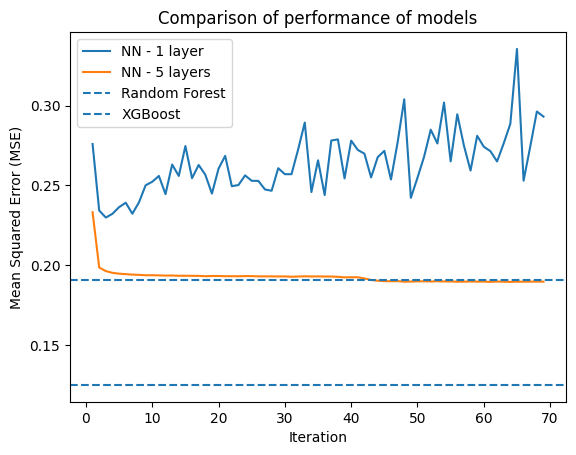

In [12]:
nn_dict = {
    'NN - 1 layer': single_nn.history.history['loss'],
    'NN - 5 layers': deep_nn.history.history['loss']
}
baseline_dict = {
    'Random Forest': rfr_mse,
    # 'Random Forest (tuned)': rfr_t_mse,
    'XGBoost': xgb_mse
}

generate_plot(nn_dict, baseline_dict)

### Calculating marginal valuation of environmental attributes

Once we have a model with environmental attributes as features and log of house price as the target variable, we can begin to construct the marginal willingness to pay for environmental attributes, and therefore get a proxy for their value.

The partial derivative of `ln_price` w.r.t an input variable can be evaluated during the backwards propagation stage of the model fitting. By evaluating this derivative at a variety of samples, we can plot a valulation curve for % change in house price resulting from a percentile change in the rank of a house for a given environmental attribute.

In [ ]:
# extract the gradients from the model
points = np.arange(0, 1.05, 0.05)
gradients = calc_partial_grad(
    deep_nn,
    x_train,
    derivative_index,
    points)

# calculate gradients across 20 different points (per attribute)

# plot the derived valuation curves

### Saving models

Here we save the pre-trained models so they can be loaded and used.

In [13]:
model_dir = cwd / "outputs" / "models"

# save models as tensor objects
deep_nn.save(model_dir / "nn_layers_5")
single_nn.save(model_dir / "nn_layers_1")

# save models as joblib files
joblib.dump(rfr_model, model_dir / "random_forest.joblib")
# joblib.dump(rfr_t_model, model_dir / "random_forest_tuned.joblib")
joblib.dump(xgb_model, model_dir / "xgboost.joblib")

INFO:tensorflow:Assets written to: c:\GitHub personal\GreenValueNet\outputs\models\nn_layers_5\assets


INFO:tensorflow:Assets written to: c:\GitHub personal\GreenValueNet\outputs\models\nn_layers_5\assets


Saved artifact at 'c:\GitHub personal\GreenValueNet\outputs\models\nn_layers_5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 23), dtype=tf.float32, name='input_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2412704776784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433955680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2411987379904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433951456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433954272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410030011616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433947056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433949168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433949520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2413433961840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  24134

INFO:tensorflow:Assets written to: c:\GitHub personal\GreenValueNet\outputs\models\nn_layers_1\assets


Saved artifact at 'c:\GitHub personal\GreenValueNet\outputs\models\nn_layers_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 23), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2410030019536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410030018832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410462220128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2410030016896: TensorSpec(shape=(), dtype=tf.resource, name=None)


['c:\\GitHub personal\\GreenValueNet\\outputs\\models\\xgboost.joblib']